# Import

In [ ]:
import os
import itertools
import numpy as np
import tensorflow as tf
%tensorflow_version 1.x
from scipy import io as spio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection  import train_test_split
# !rm -r *

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
class MyPlot():
    def __init__(self,
                 nrows, 
                 ncols, 
                 figsize):
        self.fig, self.axes = plt.subplots(nrows=nrows, 
                                           ncols=ncols, 
                                           figsize=figsize)

def my_histogram(ax, data, color, title=None):
    ax.hist(data, color=color, log=True, bins=25, edgecolor='black', linewidth=1.2);
    ax.set_title(title, color="white");

def plot_random_images(images, examples=16, fig_suptitle=None, figsize=(8,8), fpath=None):

    imgs_index = np.random.choice(np.arange(len(images)), examples, replace=False)

    plot = MyPlot(int(examples/np.sqrt(examples)), 
                  int(examples/np.sqrt(examples)), 
                  figsize=figsize)
    plot.axes = plot.axes.ravel()
    image_shape = images[0].shape
    for idx, _ in enumerate(plot.axes):
        X = images[imgs_index[idx]]
        if len(image_shape) == 2:
            plot.axes[idx].imshow(X=X,cmap="gray")
        else:
            plot.axes[idx].imshow(X=X)
        plot.axes[idx].axis('off')
    plot.fig.suptitle(fig_suptitle, fontsize=16)
    if fpath:
        plot.fig.savefig(fpath)

def plot_confusion_matrix(cm,
                          classes,
                          normalize=True,
                          figsize=(7, 7),
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix without normalization')
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

def compute_uncertainties(net, X):
    # MC times predictions for a single image
    MC = 100
    p_hat = []
    for _ in range(MC):
      p_hat.append(net.predict(X))

    p_hat = np.array(p_hat)  # shape: (MC, # samples, # classes)

    # Mean over MC samples
    mean_probs_over_draw = p_hat.mean(axis=0)
    print(mean_probs_over_draw.shape)
    predictions_uncertainty = np.argmax(mean_probs_over_draw, axis=1)

    aleatoric = np.mean(p_hat * (1 - p_hat), axis=0)
    epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2

    uncertainties_among_labels = epistemic + aleatoric

    predicted_class_variances = np.asarray([uncertainty[prediction] for prediction, uncertainty in
                                            zip(predictions_uncertainty, uncertainties_among_labels)])

    return predictions_uncertainty, predicted_class_variances
    
def compute_uncertainties_softmax(net, X):
    # Uncertainty over a single output after softmax
    prediction = net.model.predict(X)
    std_predictions = np.std(prediction)

    return std_predictions
    

# Dataset
* https://www.tensorflow.org/tutorials/load_data/numpy to load numpy into tensorflow data
* https://www.tensorflow.org/api_docs/python/tf/data/experimental/shuffle_and_repeat#:~:text=For%20perfect%20shuffling%2C%20set%20the,1%2C000%20elements%20in%20the%20buffer to understand how *batch* and *shuffle* easily

Load data from csv

In [ ]:
# If I want to try one hot encoding, I must remember to change 1D to 2D in the network

In [ ]:
class ProteinEncoder:
  def __init__(self):

    ascii_uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    self.ordinal_encoding = {ascii_uppercase[i]: '{0:05b}'.format(i) for i in range(len(ascii_uppercase))}
    print(self.ordinal_encoding)
    self.one_hot_len = 5  # number of bits to represent letters in the alphabet
    
  def ordinal(self, sequence):
    # Ordinally encode the sequences

    encoded_seq = []
    for letter in sequence:
      encoded_seq.append(self.ordinal_encoding[letter])

    # keep track of the length for padding
    return encoded_seq, len(encoded_seq)


  def one_hot(self, sequence):
    
    encoding = np.zeros((len(sequence), self.one_hot_len))
    for i, letter in enumerate(sequence):
      one_hot_index = self.ordinal_encoding[letter]
      encoding[i, one_hot_index] = 1

    return encoding, len(sequence) # Still need to be padded

In [ ]:
encoder = ProteinEncoder()
max_len = 0

path2data  = '/content/drive/MyDrive/Bioinfo/EXAM/LAB6/'


# Training dataset
X_train = []
y_train = []
with open(path2data + 'training_set.csv', 'r') as f:
  # Remove header
  _ = f.readline()

  # Map line to the a list with the sequences of aberrant proteins
  for line in f:
    fields = line.split('\t')
    label = fields[2]
    proteins_string = fields[19][1:-1]
    protein_list = proteins_string.split(', ')

    for seq in protein_list:
      encoded_seq, seq_len = encoder.one_hot(seq[1:-2])
      X_train.append(encoded_seq)
      y_train.append(int(label))

    if max_len < seq_len:
          max_len = seq_len

{'A': '00000', 'B': '00001', 'C': '00010', 'D': '00011', 'E': '00100', 'F': '00101', 'G': '00110', 'H': '00111', 'I': '01000', 'J': '01001', 'K': '01010', 'L': '01011', 'M': '01100', 'N': '01101', 'O': '01110', 'P': '01111', 'Q': '10000', 'R': '10001', 'S': '10010', 'T': '10011', 'U': '10100', 'V': '10101', 'W': '10110', 'X': '10111', 'Y': '11000', 'Z': '11001'}


IndexError: ignored

In [ ]:
# Test dataset
X_test = []
y_test = []
with open(path2data + 'test_set_1.csv', 'r') as f:
  # Remove header
  _ = f.readline()

  # Map line to the a list with the sequences of aberrant proteins
  for line in f:
    fields = line.split('\t')
    label = fields[2]
    proteins_string = fields[19][2:-2]
    protein_list = proteins_string.split(', ')

    for seq in protein_list:
      encoded_seq, _ = encoder.one_hot(seq[1:-2])
      X_test.append(encoded_seq)
      y_test.append(int(label))

## Padding

In [ ]:
# Pad only considering train data, since I should not have access to test data for preprocessing

In [ ]:
padding_seq = np.expand_dims([0 for _ in range(26)], axis=0)
for seq in X_train:
  sequence_length = len(seq)
  pad_length = max_len - sequence_length
  for _ in range(pad_length):
    np.concatenate([seq, padding_seq], axis=0)
  
for seq in X_test:
  sequence_length = len(seq)
  pad_length = max_len - sequence_length
  for _ in range(pad_length):
    np.concatenate([seq, padding_seq], axis=0)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Model

In [ ]:
class MyModel():

  def __init__(self,
               epochs,
               batch_size,
               learning_rate,
               input_shape,
               p_dropout,
               lr_reduction_epoch,
               deterministic = None,
               loss = 'sparse_categorical_crossentropy',
               num_classes = 2
               ):
    
    self.epochs = epochs
    self.lr = learning_rate
    self.batch_size = batch_size
    self.input_shape = input_shape
    self.p_dropout = p_dropout
    self.lr_reduction_epoch = lr_reduction_epoch 
    self.loss = loss
    self.num_classes = num_classes


    if deterministic:
      self.deterministic_model()

    else:
      self.dropout_model()


  def block_1(self, conv_i, max_pool_j, filters, x, bayesian = False, kernel = 5, pool_size = 2, strides = 2):

      x = tf.keras.layers.Conv1D(filters,
                                kernel_size = kernel,
                                padding = 'same',
                                activation = 'relu',
                                name = f"conv{conv_i}")(x)
      if bayesian:
        x = tf.keras.layers.Dropout(self.p_dropout)(x, training=True)

      x = tf.keras.layers.MaxPooling1D(pool_size = pool_size,
                                       strides = strides,
                                       padding="same", 
                                       name = f"pool{max_pool_j}")(x)
      
      # No dropout after MaxPooling, since it is not trainable


      return x, conv_i+1, max_pool_j+1


  def block_2(self, conv_i, max_pool_j, filters, x, bayesian = False, kernel = 5, pool_size = 2, strides = 2):
      
      
      x = tf.keras.layers.Conv1D(filters,
                                kernel_size = kernel,
                                padding = 'same',
                                activation = 'relu',
                                name = f"conv{conv_i}")(x)
      if bayesian:
        x = tf.keras.layers.Dropout(self.p_dropout)(x, training=True)
      x = tf.keras.layers.MaxPooling1D(pool_size = pool_size,
                                      strides = 1,
                                      padding="same", 
                                      name = f"pool{max_pool_j}")(x)
      x = tf.keras.layers.Conv1D(filters,
                                kernel_size = kernel,
                                padding = 'same',
                                activation = 'relu',
                                name = f"conv{conv_i+1}")(x)
      if bayesian:
        x = tf.keras.layers.Dropout(self.p_dropout)(x, training=True)
      x = tf.keras.layers.MaxPooling1D(pool_size = pool_size,
                                      strides = strides,
                                      padding="same", 
                                      name = f"pool{max_pool_j+1}")(x)
                            

      return x, conv_i+2, max_pool_j+2


  def deterministic_model(self):

      # VGG16 1D implementation
      # https://www.researchgate.net/figure/Block-schemes-for-VGG-like-and-ResNet-like-1D-convolutional-neural-networks-Red_fig3_328136578
      inputs = tf.keras.layers.Input(shape=self.input_shape)
      out1, conv_i, max_pool_j = self.block_1(1, 1, 8,
                                              x=inputs)
      out2, conv_i, max_pool_j = self.block_1(conv_i, max_pool_j, 16,
                                                x=out1)
      out3, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 32,
                                                x=out2)
      out4, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 64,
                                                x=out3)
      out5, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 128,
                                                x=out4)
      out6, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 256,
                                                x=out5)
      out7, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 512,
                                                x=out6)
      out8, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 1024,
                                                x=out7)
      
      x = tf.keras.layers.Flatten()(out8)
      x = tf.keras.layers.Dense(256,
                              activation = 'relu',
                              name = "fc1")(x)
      x = tf.keras.layers.Dropout(self.p_dropout)(x)
      x = tf.keras.layers.Dense(128,
                              activation = 'relu',
                              name = "fc2")(x)
      x = tf.keras.layers.Dropout(self.p_dropout)(x)
      x = tf.keras.layers.Dense(12,
                              activation = 'relu',
                              name = "fc3")(x)
      outputs = tf.keras.layers.Dense(self.num_classes,
                              activation = 'softmax',
                              name = "fc4")(x)             

      self.model = tf.keras.Model(inputs=inputs, outputs=outputs)     
      
      out_str = "VGG16 model deterministic built"
      print('#'*len(out_str))
      print(out_str)
      print('#'*len(out_str))


  def dropout_model(self):

    # VGG16 1D implementation
    # https://www.researchgate.net/figure/Block-schemes-for-VGG-like-and-ResNet-like-1D-convolutional-neural-networks-Red_fig3_328136578
    inputs = tf.keras.layers.Input(shape=self.input_shape)
    out1, conv_i, max_pool_j = self.block_1(1, 1, 8,
                                            x=inputs, bayesian = True)
    out2, conv_i, max_pool_j = self.block_1(conv_i, max_pool_j, 16,
                                              x=out1, bayesian = True)
    out3, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 32,
                                              x=out2, bayesian = True)
    out4, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 64,
                                              x=out3, bayesian = True)
    out5, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 128,
                                              x=out4, bayesian = True)
    out6, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 256,
                                              x=out5, bayesian = True)
    out7, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 512,
                                              x=out6, bayesian = True)
    out8, conv_i, max_pool_j = self.block_2(conv_i, max_pool_j, 1024,
                                              x=out7, bayesian = True)
    
    x = tf.keras.layers.Flatten()(out8)
    x = tf.keras.layers.Dense(256,
                            activation = 'relu',
                            name = "fc1")(x)
    x = tf.keras.layers.Dropout(self.p_dropout)(x)
    x = tf.keras.layers.Dense(128,
                            activation = 'relu',
                            name = "fc2")(x)
    x = tf.keras.layers.Dropout(self.p_dropout)(x)
    x = tf.keras.layers.Dense(12,
                            activation = 'relu',
                            name = "fc3")(x)
    outputs = tf.keras.layers.Dense(self.num_classes,
                            activation = 'softmax',
                            name = "fc4")(x)             

    self.model = tf.keras.Model(inputs=inputs, outputs=outputs)     
    
    out_str = "VGG16 model dropout built"
    print('#'*len(out_str))
    print(out_str)
    print('#'*len(out_str))


  def train_model(self, X, y):
    # Define training pipeline

    X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.1, random_state=42, stratify = True)

    # Define the optimizer and the learning rate
    optim = tf.keras.optimizers.Adam(learning_rate = self.lr)

    # Compile the model with the optimizer and define the loss function
    self.model.compile(optim, self.loss, metrics=['accuracy'])

    # Define the callbacks
    my_callbacks = [
                 tf.keras.callbacks.LearningRateScheduler(self.lr_scheduler),
                 tf.keras.callbacks.History()
               ]


    self.model.fit(x=X_train, 
                      y=y_train, 
                      batch_size=self.batch_size,
                      epochs=self.epochs,
                      validation_data = (X_test, y_test),
                      callbacks=my_callbacks)
  
    
  def lr_scheduler(self, epoch, lr):
    if epoch in self.lr_reduction_epoch:
      return lr *0.1

    return lr
    

# Train

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
P_DROPOUT = 0.5
EPOCH_SCHEDULE = [5, 15]

In [ ]:
input_shape = (X_train[0].shape[0], 1)

In [ ]:
# Deterministic
det_net = MyModel(EPOCHS,
              BATCH_SIZE,
              LEARNING_RATE,
              input_shape, 
              P_DROPOUT,
              EPOCH_SCHEDULE,
              deterministic = True)

det_net.train_model(X_train, y_train)

###############################
VGG16 model deterministic built
###############################
Epoch 1/20
60/60 [==============================] - 4s 39ms/step - loss: 0.6973 - accuracy: 0.5484 - val_loss: 0.6168 - val_accuracy: 0.6840
Epoch 2/20
60/60 [==============================] - 2s 29ms/step - loss: 0.6054 - accuracy: 0.6673 - val_loss: 0.6463 - val_accuracy: 0.6321
Epoch 3/20
60/60 [==============================] - 2s 29ms/step - loss: 0.6126 - accuracy: 0.6934 - val_loss: 0.4702 - val_accuracy: 0.7925
Epoch 4/20
60/60 [==============================] - 2s 29ms/step - loss: 0.5343 - accuracy: 0.7585 - val_loss: 0.4794 - val_accuracy: 0.7736
Epoch 5/20
60/60 [==============================] - 2s 29ms/step - loss: 0.5449 - accuracy: 0.7529 - val_loss: 0.4951 - val_accuracy: 0.8349
Epoch 6/20
60/60 [==============================] - 2s 29ms/step - loss: 0.4811 - accuracy: 0.7959 - val_loss: 0.4747 - val_accuracy: 0.8160
Epoch 7/20
60/60 [==============================] - 2s 29m

In [ ]:
# Dropout
drop_net = MyModel(EPOCHS,
              BATCH_SIZE,
              LEARNING_RATE,
              input_shape, 
              P_DROPOUT,
              EPOCH_SCHEDULE)

drop_net.train_model(X_train, y_train)

#########################
VGG16 model dropout built
#########################
Epoch 1/20
60/60 [==============================] - 4s 38ms/step - loss: 16.3022 - accuracy: 0.5843 - val_loss: 0.6431 - val_accuracy: 0.6321
Epoch 2/20
60/60 [==============================] - 2s 31ms/step - loss: 0.6503 - accuracy: 0.6173 - val_loss: 0.6123 - val_accuracy: 0.7123
Epoch 3/20
60/60 [==============================] - 2s 31ms/step - loss: 0.6255 - accuracy: 0.6522 - val_loss: 0.5766 - val_accuracy: 0.6745
Epoch 4/20
60/60 [==============================] - 2s 31ms/step - loss: 0.6348 - accuracy: 0.6466 - val_loss: 0.5744 - val_accuracy: 0.7689
Epoch 5/20
60/60 [==============================] - 2s 31ms/step - loss: 0.6184 - accuracy: 0.6849 - val_loss: 0.5605 - val_accuracy: 0.7500
Epoch 6/20
60/60 [==============================] - 2s 31ms/step - loss: 0.6170 - accuracy: 0.6705 - val_loss: 0.5639 - val_accuracy: 0.7736
Epoch 7/20
60/60 [==============================] - 2s 31ms/step - loss: 0.

# Test

In [ ]:
# Deterministic
predictions = np.argmax(det_net.model.predict(X_test), axis=1)
accuracy = np.sum(np.array(predictions == y_test))/len(predictions)
print(accuracy)

0.17857142857142858


In [ ]:
# Dropout
predictions = np.argmax(drop_net.model.predict(X_test), axis=1)
accuracy = np.sum(np.array(predictions == y_test))/len(predictions)
print(accuracy)

0.3392857142857143


# Compute uncertainties for Gene Fusions dataset

(896, 2)


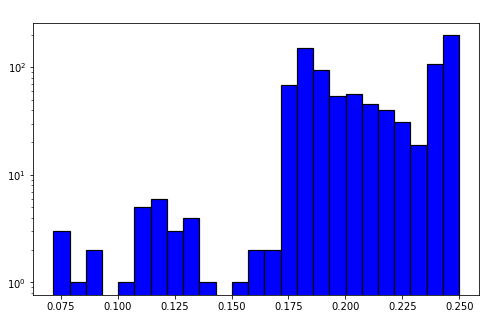

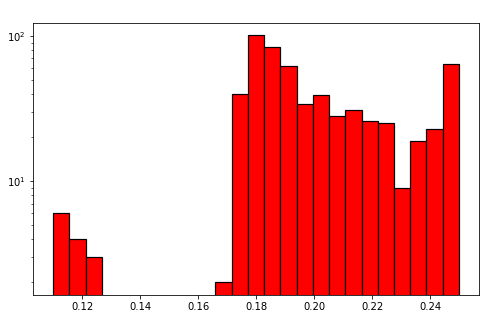

In [ ]:
predictions_uncertainty, predicted_class_variances = compute_uncertainties(drop_net.model, X_test)
title = "Gene Fusion test - All predictions"
plot = MyPlot(1, 1, (8,5))
my_histogram(plot.axes, predicted_class_variances, 'b', title)

title = "Gene Fusion test - False predictions"
plot = MyPlot(1, 1, (8,5))
not_corret_preds = predicted_class_variances[y_test != predictions]
my_histogram(plot.axes, not_corret_preds, 'r', title)

# Softmax uncertainty

ValueError: ignored

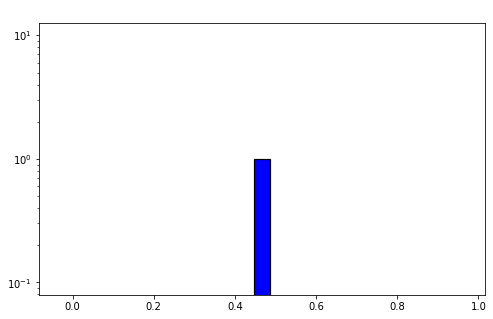

In [ ]:
softmax_uncertainty = compute_uncertainties_softmax(det_net,
                                                    X_test)

title = "EMNIST test - All predictions - softmax uncertainty"
plot = MyPlot(1, 1, (8, 5))
my_histogram(plot.axes, softmax_uncertainty, 'b', title)

sure = np.where(softmax_uncertainty < 0.15)[0]
title = "softmax uncertainty Predizioni incerte"
plot_random_images(np.squeeze(X_test[sure]), examples=100, fig_suptitle=title, figsize=(16, 16))

uncertain = np.where(softmax_uncertainty > 0.26)[0]
title = "softmax uncertainty Predizioni sicure"
plot_random_images(np.squeeze(X_test[uncertain]), examples=100, fig_suptitle=title, figsize=(16, 16))

# Conclusions
Quello che abbiamo fatto è stato
* Trainare la rete con dropout: in questo caso il training è un training normale, solo con un dropout molto elevato (che infatti comporta una leggera perdita in termini di accuracy rispetto alla rete deterministica)
* Dopodiché abbiamo testato la rete **con dropout attivo** : dropout at inference time. Non so se sia corretto, ora indago (a me interessa dropout attivo solo se voglio calcolare l'incertezza. Ad ogni modo anche lui ha fatto così)
* Infine abbiamo ripetuto il test per MC volte, per ogni sample, e per ogni sample abbiamo calcolato la sua incertezza rispetto alla label che gli abbiamo assegnato
* Usando le predizioni e i valori di incertezza, abbiamo comparato i valori di incertezza per le previsioni corrette e quelle errate, ottenendo, inaspettatamente, un andamento pressoché identico (cosi come gia successo la prima volta che ho fatto LAB 6).

Una possibile spiegazione è dovuta al fatto che la rete non è in grado di classificare bene i samples, a prescindere dal fatto che la classificazione sia corretta o meno, perché le features fornite non sono sufficienti: in questo senso, tutti i sample risultano "difficili"